In [1]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc3 as pm
import seaborn as sns
from pymc3 import math
from scipy import stats
import theano
import theano.tensor as tt

([], [])

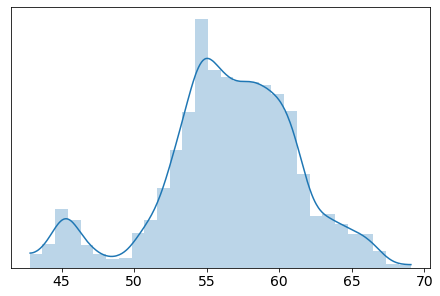

In [8]:
cs = pd.read_csv('../data/chemical_shifts_theo_exp.csv')
cs_exp = cs['exp']
az.plot_kde(cs_exp)
plt.hist(cs_exp, density=True, bins=30, alpha=0.3)
plt.yticks([])

Bad model

"The reason for such
difficulties is that in model_kg we have explicitly included the latent variable in the
model. One problem with this explicit approach is that sampling the discrete variable
usually leads to slow mixing and ineffective exploration of the tails of the distribution"

In [4]:
clusters = 2

with pm.Model() as model_kg:
    p = pm.Dirichlet('p', a=np.ones(clusters))
    z = pm.Categorical('z', p=p, shape=len(cs_exp))
    means = pm.Normal('means', mu=cs_exp.mean(), sd=10, shape=clusters)
    sd = pm.HalfNormal('sd', sd=10)
    y = pm.Normal('y', mu=means[z], sd=sd, observed=cs_exp)
    trace_kg = pm.sample()

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [sd, means, p]
>BinaryGibbsMetropolis: [z]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 558 seconds.
C:\Users\emilr\Anaconda3\envs\CM\lib\site-packages\arviz\stats\diagnostics.py:642: RuntimeWarning: divide by zero encountered in double_scalars
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


"One way to solve these sampling problems is by reparametrizing the model"

In [ ]:
clusters = 2
with pm.Model() as model_mg:
    p = pm.Dirichlet('p', a=np.ones(clusters))
    means = pm.Normal('means', mu=cs_exp.mean(), sd=10, shape=clusters)
    sd = pm.HalfNormal('sd', sd=10)
    y = pm.NormalMixture('y', w=p, mu=means, sd=sd, observed=cs_exp)
    
    trace_mg = pm.sample(random_seed=123)

In [5]:
varnames = ['means', 'p']
az.plot_trace(trace_mg, varnames)

NameError: name 'trace_mg' is not defined

In [ ]:
az.summary(trace_mg, varnames)

Solving the "parameter non-identifiability"

"Empirical evidence suggests that values of (alpha = 4 or 10) are generally a good default choice as these values usually lead to posteriors distributions with each component having at least one data point
assigned to them while reducing the chance of overestimating the number of components"

In [6]:
clusters = 2
with pm.Model() as model_mgp:
    p = pm.Dirichlet('p', a=np.ones(clusters))
    p_min = pm.Potential('p_min', tt.switch(tt.min(p) < 0.001, -np.inf, 0))
    means = pm.Normal('means', mu=np.array([.9, 1]) * cs_exp.mean(), sd=10, shape=clusters)
    sd = pm.HalfNormal('sd', sd=10)

    order_means = pm.Potential('order_means', tt.switch(means[1]-means[0] < 0, -np.inf, 0))

    y = pm.NormalMixture('y', w=p, mu=means, sd=sd, observed=cs_exp)

    trace_mgp = pm.sample(1000, random_seed=123)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sd, means, p]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 25 seconds.


array([[<AxesSubplot:title={'center':'means'}>,
        <AxesSubplot:title={'center':'means'}>],
       [<AxesSubplot:title={'center':'p'}>,
        <AxesSubplot:title={'center':'p'}>]], dtype=object)

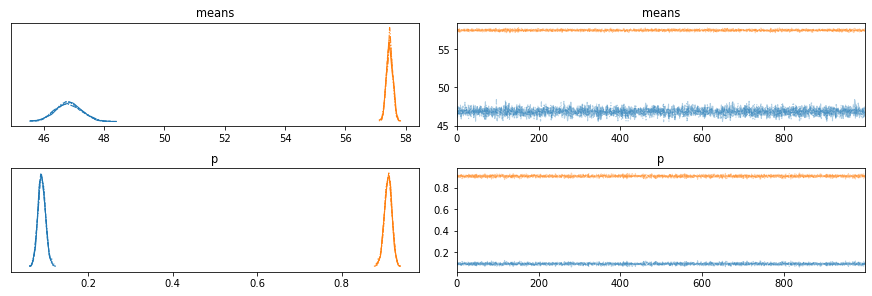

In [7]:
varnames = ['means', 'p']
az.plot_trace(trace_mgp, varnames)

In [8]:
az.summary(trace_mgp)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
means[0],46.821,0.431,46.017,47.615,0.007,0.005,4027.0,4027.0,4029.0,3466.0,1.0
means[1],57.463,0.103,57.276,57.654,0.002,0.001,4603.0,4603.0,4622.0,2892.0,1.0
p[0],0.090,0.009,0.073,0.107,0.000,0.000,3838.0,3838.0,3813.0,2899.0,1.0
p[1],0.910,0.009,0.893,0.927,0.000,0.000,3838.0,3831.0,3813.0,2899.0,1.0
sd,3.653,0.076,3.508,3.795,0.001,0.001,4478.0,4462.0,4517.0,3138.0,1.0


In [3]:
clusters = [3, 4, 5, 6]
models = []
traces = []

for cluster in clusters:
    with pm.Model() as model:
        p = pm.Dirichlet('p', a=np.ones(cluster))
        means = pm.Normal('means',
        mu=np.linspace(cs_exp.min(), cs_exp.max(), cluster), sd=10, shape=cluster, transform=pm.distributions.transforms.ordered)
        sd = pm.HalfNormal('sd', sd=10)
        y = pm.NormalMixture('y', w=p, mu=means, sd=sd, observed=cs_exp)
        trace = pm.sample(1000, tune=2000, random_seed=123)
        traces.append(trace)
        models.append(model)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sd, means, p]


Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 59 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sd, means, p]


Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 63 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sd, means, p]


Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 114 seconds.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6779921033057935, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sd, means, p]


Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 191 seconds.
There were 536 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.4794232906105278, but should be close to 0.8. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.


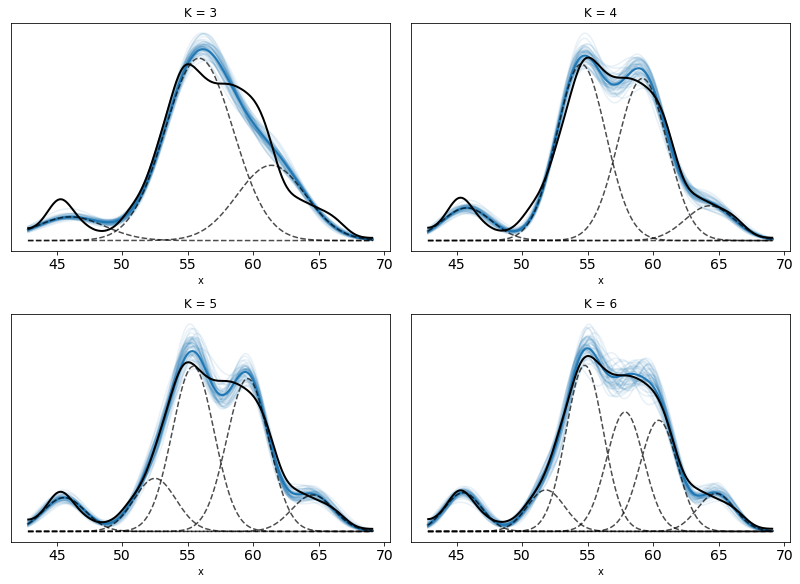

In [10]:
_, ax = plt.subplots(2, 2, figsize=(11, 8), constrained_layout=True)
ax = np.ravel(ax)
x = np.linspace(cs_exp.min(), cs_exp.max(), 200)

for idx, trace_x in enumerate(traces):
    x_ = np.array([x] * clusters[idx]).T

    for i in range(50):
        i_ = np.random.randint(0, len(trace_x))
        means_y = trace_x['means'][i_]
        p_y = trace_x['p'][i_]
        sd = trace_x['sd'][i_]
        dist = stats.norm(means_y, sd)
        ax[idx].plot(x, np.sum(dist.pdf(x_) * p_y, 1), 'C0', alpha=0.1)

    means_y = trace_x['means'].mean(0)
    p_y = trace_x['p'].mean(0)
    sd = trace_x['sd'].mean()
    dist = stats.norm(means_y, sd)
    ax[idx].plot(x, np.sum(dist.pdf(x_) * p_y, 1), 'C0', lw=2)
    ax[idx].plot(x, dist.pdf(x_) * p_y, 'k--', alpha=0.7)
    az.plot_kde(cs_exp, plot_kwargs={'linewidth':2, 'color':'k'}, ax=ax[idx])
    ax[idx].set_title('K = {}'.format(clusters[idx]))
    ax[idx].set_yticks([])
    ax[idx].set_xlabel('x')

In [ ]:
ppc_mm = [pm.sample_posterior_predictive(traces[i], 1000, models[i]) for i in range(4)]

fig, ax = plt.subplots(2, 2, figsize=(10, 6), sharex=True, constrained_layout=True)
ax = np.ravel(ax)
def iqr(x, a=0):
    return np.subtract(*np.percentile(x, [75, 25], axis=a))

T_obs = iqr(cs_exp)
for idx, d_sim in enumerate(ppc_mm):
    T_sim = iqr(d_sim['y'][:100].T, 1)
    p_value = np.mean(T_sim >= T_obs)
    az.plot_kde(T_sim, ax=ax[idx])
    ax[idx].axvline(T_obs, 0, 1, color='k', ls='--')
    ax[idx].set_title(f'K = {clusters[idx]} \n p-value {p_value:.2f}')
    ax[idx].set_yticks([])

In [ ]:
comp = az.compare(dict(zip(clusters, traces)), method='BB-pseudo-BMA')
comp

In [ ]:
az.plot_compare(comp)

### Non-finite mixture model

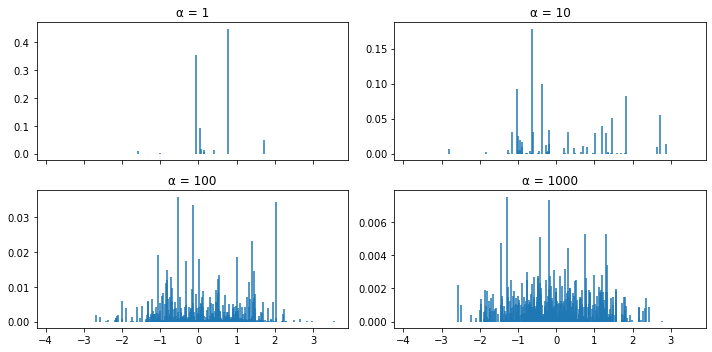

In [6]:
def stick_breaking_truncated(α, H, K):
    """
    Truncated stick-breaking process view of a DP
    Parameters
    ----------
    α : float
    concentration parameter
    H : scipy distribution
    Base distribution
    K : int
    number of components
    Returns
    -------
    locs : array
    locations
    w : array probabilities
    """
    βs = stats.beta.rvs(1, α, size=K)
    w = np.empty(K)
    w = βs * np.concatenate(([1.], np.cumprod(1 - βs[:-1])))
    locs = H.rvs(size=K)
    return locs, w

# Parameters DP
K = 500
H = stats.norm
alphas = [1, 10, 100, 1000]
_, ax = plt.subplots(2, 2, sharex=True, figsize=(10, 5))
ax = np.ravel(ax)
for idx, α in enumerate(alphas):
    locs, w = stick_breaking_truncated(α, H, K)
    ax[idx].vlines(locs, 0, w, color='C0')
    ax[idx].set_title('α = {}'.format(α))
plt.tight_layout()


([], [])

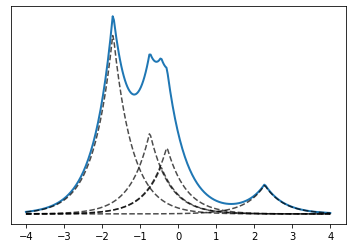

In [7]:
α = 10
H = stats.norm
K = 5
x = np.linspace(-4, 4, 250)
x_ = np.array([x] * K).T
locs, w = stick_breaking_truncated(α, H, K)
dist = stats.laplace(locs, 0.5)
plt.plot(x, np.sum(dist.pdf(x_) * w, 1), 'C0', lw=2)
plt.plot(x, dist.pdf(x_) * w, 'k--', alpha=0.7)
plt.yticks([])

### Lets implement cool shit

In [10]:
N = cs_exp.shape[0]
K = 20
def stick_breaking(α):
    β = pm.Beta('β', 1., α, shape=K)
    w = β * pm.math.concatenate([[1.], tt.extra_ops.cumprod(1. - β)[:-1]])
    return w

In [12]:
with pm.Model() as model:
    α = pm.Gamma('α', 1., 1.)
    w = pm.Deterministic('w', stick_breaking(α))
    means = pm.Normal('means', mu=cs_exp.mean(), sd=10, shape=K)
    sd = pm.HalfNormal('sd', sd=10, shape=K)
    obs = pm.NormalMixture('obs', w, means, sd=sd, observed=cs_exp.values)
    trace = pm.sample(1000, tune=2000, target_accept = 0.9)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sd, means, β, α]


In [ ]:
az.plot_trace(trace)

## Exercises:

1. Generate synthetic from a mixture of three Gaussians. Check the accompanying Jupyter Notebook for this chapter for an example on how to do this. Fit a finite Gaussian mixture model with 2, 3, or 4 components.

<AxesSubplot:>

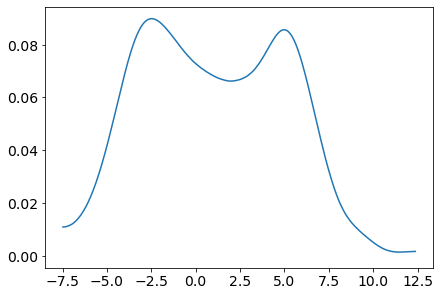

In [2]:
# Generate synthetic (from https://github.com/PacktPublishing/Bayesian-Analysis-with-Python-Second-Edition/blob/master/Chapter06/06_mixture_models.ipynb)

clusters = 3
n_cluster = [200, 150, 170]
n_total = sum(n_cluster)
means = [5, 0, -3]
std_devs = [2, 2, 2]
mix = np.random.normal(np.repeat(means, n_cluster), np.repeat(std_devs, n_cluster))
az.plot_kde(np.array(mix))

In [13]:
clusters = [2, 3, 4]
models = []
traces = []

for cluster in clusters:
    with pm.Model() as model:
        p = pm.Dirichlet('p', a=np.ones(cluster))
        means = pm.Normal('means', mu=np.linspace(mix.min(), mix.max(), cluster), sd=10, shape = cluster, transform=pm.distributions.transforms.ordered) 
        sd = pm.HalfNormal('sd', sd=10)
        y = pm.NormalMixture('y', w=p, mu=means, sd=sd, observed=mix)
        trace = pm.sample(1000, tune=1000, random_seed=123)

        traces.append(trace)
        models.append(model)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sd, means, p]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 27 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sd, means, p]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 56 seconds.
There were 3 divergences after tuning. Increase `target_accept` or reparameterize.
There were 200 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.5128952503640156, but should be close to 0.8. Try to increase the number of tuning steps.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
There were 3 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sd, means, p]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 78 seconds.
There were 406 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.2829378613030644, but should be close to 0.8. Try to increase the number of tuning steps.
There were 30 divergences after tuning. Increase `target_accept` or reparameterize.
There were 13 divergences after tuning. Increase `target_accept` or reparameterize.
There were 301 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.44482225514940693, but should be close to 0.8. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


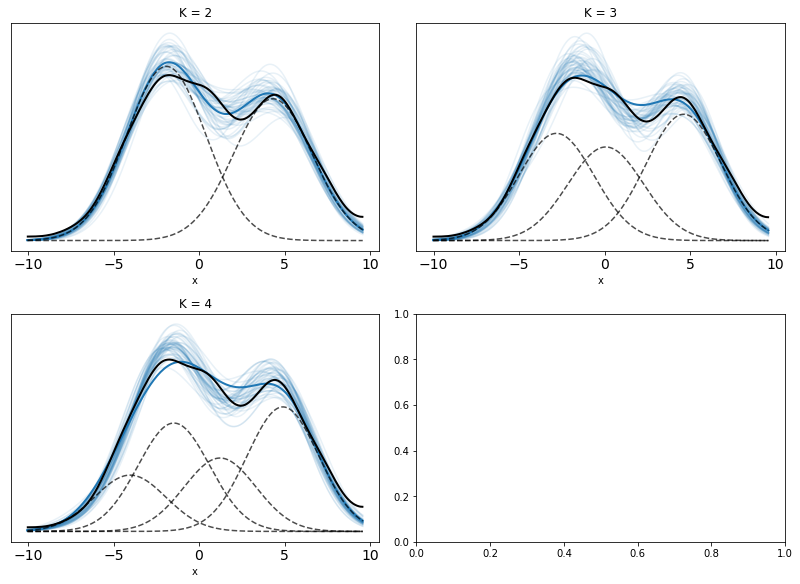

In [14]:
_, ax = plt.subplots(2, 2, figsize=(11, 8), constrained_layout=True)
ax = np.ravel(ax)
x = np.linspace(mix.min(), mix.max(), 200)

for idx, trace_x in enumerate(traces):
    x_ = np.array([x] * clusters[idx]).T

    for i in range(50):
        i_ = np.random.randint(0, len(trace_x))
        means_y = trace_x['means'][i_]
        p_y = trace_x['p'][i_]
        sd = trace_x['sd'][i_]
        dist = stats.norm(means_y, sd)
        ax[idx].plot(x, np.sum(dist.pdf(x_) * p_y, 1), 'C0', alpha=0.1)

    means_y = trace_x['means'].mean(0)
    p_y = trace_x['p'].mean(0)
    sd = trace_x['sd'].mean()
    dist = stats.norm(means_y, sd)
    ax[idx].plot(x, np.sum(dist.pdf(x_) * p_y, 1), 'C0', lw=2)
    ax[idx].plot(x, dist.pdf(x_) * p_y, 'k--', alpha=0.7)
    az.plot_kde(mix, plot_kwargs={'linewidth':2, 'color':'k'}, ax=ax[idx])
    ax[idx].set_title('K = {}'.format(clusters[idx]))
    ax[idx].set_yticks([])
    ax[idx].set_xlabel('x')

In [15]:
ppc_mm = [pm.sample_posterior_predictive(traces[i], 1000, models[i]) for i in range(3)]

C:\Users\emilr\Anaconda3\envs\CM\lib\site-packages\pymc3\sampling.py:1688: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  warnings.warn(


C:\Users\emilr\Anaconda3\envs\CM\lib\site-packages\pymc3\sampling.py:1688: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  warnings.warn(


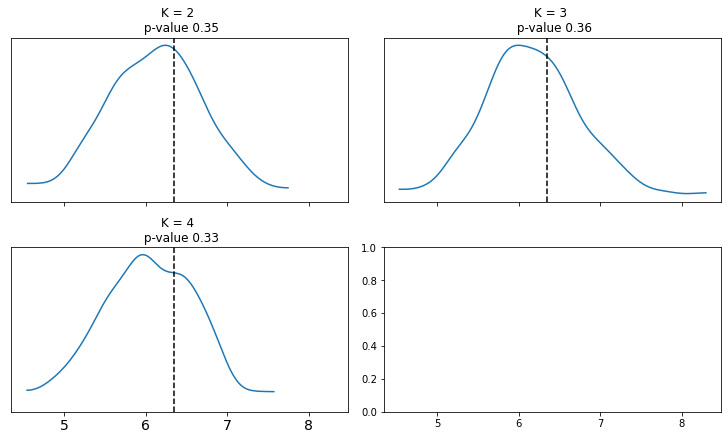

In [21]:

fig, ax = plt.subplots(2, 2, figsize=(10, 6), sharex=True, constrained_layout=True)
ax = np.ravel(ax)
def iqr(x, a=0):
    return np.subtract(*np.percentile(x, [75, 25], axis=a))

T_obs = iqr(mix)
for idx, d_sim in enumerate(ppc_mm):
    T_sim = iqr(d_sim['y'][:100].T, 1)
    p_value = np.mean(T_sim >= T_obs)
    az.plot_kde(T_sim, ax=ax[idx])
    ax[idx].axvline(T_obs, 0, 1, color='k', ls='--')
    ax[idx].set_title(f'K = {clusters[idx]} \n p-value {p_value:.2f}')
    ax[idx].set_yticks([])

### Exercise 2
Use WAIC and LOO to compare the results from exercise 1

In [23]:
comp = az.compare(dict(zip(clusters, traces)), method='BB-pseudo-BMA')
comp

C:\Users\emilr\Anaconda3\envs\CM\lib\site-packages\arviz\stats\stats.py:146: UserWarning: The default method used to estimate the weights for each model,has changed from BB-pseudo-BMA to stacking
  warnings.warn(


,rank,loo,p_loo,d_loo,weight,se,dse,warning,loo_scale
4,0,-1420.864039,4.978998,0.000000,0.462355,12.277600,0.000000,False,log
3,1,-1421.220368,4.564169,0.356329,0.308388,12.234877,0.456123,False,log
2,2,-1421.589263,4.119606,0.725224,0.229257,12.150504,0.821118,False,log


### Comments from the group:

### Exercise 3
Any idiot would probably be able to run the exercises from these tutorials:

Marginalized Gaussian Mixture Model:
https:/​/​docs.​pymc.​io/notebooks/​marginalized_​gaussian_​mixture_​model.​html

Dependent density regression:
https:/​/​docs.​pymc.​io/​notebooks/dependent_​density_​regression.​html

Gaussian Mixture Model with ADVI:
https:/​/​docs.​pymc.​io/notebooks/​gaussian-​mixture-​model-​advi.​html 

### Exercise 4:
Repeat exercise 1 using a Dirichlet process

In [3]:
#Okay, Okay, now this shit is gettin' interesting (he says at 23:48)
#Start with the stick_breaking thing from chapter:
N = mix.shape[0]
K = 20

def stick_breaking(α):
    β = pm.Beta('β', 1., α, shape=K)
    w = β * pm.math.concatenate([[1.], tt.extra_ops.cumprod(1. - β)[:-1]])
    return w

In [4]:
#perfect, now we "just" need to build a model
with pm.Model() as model2:
    α = pm.Gamma('α', 1., 1.)
    w = pm.Deterministic('w', stick_breaking(α))
    means = pm.Normal('means', mu=mix.mean(), sd=10, shape=K)
    sd = pm.HalfNormal('sd', sd=10, shape=K)
    obs = pm.NormalMixture('obs', w, means, sd=sd, observed=mix)
    
    trace2 = pm.sample(1000, tune=2000, target_accept = 0.9)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sd, means, β, α]


### Exercise 5:
Assuming for a moment that you do not know the correct species/labels for the
Iris dataset, use a mixture model to cluster the three iris species, using one
feature of your choice (like the length of the sepal).

### Exercise 6
Repeat exercise 5 but this time using two features